# Comparative analysis of transformation methods

## No Transformation, Log Transformation, and Box-Cox Transformation

This study investigates the impact of three data pre-treatment methods on model performance using a calibration dataset:

1. **No Transformation** (linear scale): `y_ori`
2. **Logarithmic Transformation** (log scale): `y_log`
3. **Box-Cox Transformation** (Box-Cox scale): `y_box`

Random Forest (RF) models were applied in a naive setup (without feature selection or hyperparameter optimization) to each dataset. Cross-validation (CV) was performed to evaluate model performance under each transformation. 


In [1]:
import sys
import pathlib
import os
from skmap.catalog import s3_setup, DataCatalog
from skmap.loader import TiledDataLoader
from skmap.overlay import SpaceOverlay, SpaceTimeOverlay
from skmap.misc import find_files, GoogleSheet, ttprint
import random
import pandas as pd
import time
import skmap_bindings as sb
import numpy as np
import geopandas as gpd
import json
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_score, HalvingGridSearchCV, KFold, GroupKFold, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, median_absolute_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from model_fit import read_features, parameter_fine_tuning, evaluate_model, calc_ccc, separate_data, calc_metrics
import joblib

from scipy.stats import boxcox
from scipy.special import inv_boxcox

folder_path = '/home/xuemeng/work_xuemeng/soc/SoilHealthDataCube'

# Prepare

In [2]:
# read in
# data
cal = pd.read_parquet(f'{folder_path}/data/005_data_cal.pq')
# features
with open(f'{folder_path}/data/007_cov_all.json', "r") as file:
    covs = json.load(file)
print('cov number: ', len(covs))
    
# initialize some parameter
n_jobs=90
cv = GroupKFold(n_splits=5) 
rsl = []

# set a naive model
rf = RandomForestRegressor(random_state=40, n_jobs=80, n_estimators=100)


cov number:  585


### Box-Cox Transformation Note

The **Box-Cox Transformation** requires all input values to be strictly positive (\> 0 \). However, our training dataset contained zero values, which cannot be directly processed by this transformation.

To address this, we added a small constant \( 0.000001 \) to these zero values. This adjustment ensured that the dataset met the positivity constraint while minimally altering the data.

For a fair comparison, the other two pre-treatment methods—**No Transformation** and **Logarithmic Transformation**—were also applied to this adjusted, non-zero dataset.

In [3]:
# make the data non-zero
prop = 'ocd_nz'
cal[f'ocd_nz'] = cal['ocd']
cal.loc[cal[f'ocd_nz']==0, f'ocd_nz'] = 0.000001

# apply transformation
tgt = f'{prop}_log1p'
cal[tgt] = np.log1p(cal[prop])

tgt2 = f'{prop}_boxcox'
cal[tgt2],fitted_lambda= boxcox(cal[prop],lmbda=None)
print(f'the fitted lambda is {fitted_lambda}')

the fitted lambda is 0.3060605262669862


# Metrics

The results were analyzed using the following performance metrics:

- **Mean Absolute Error (MAE)**
- **Median Absolute Error (MedAE)**
- **Bias (Mean Error)** (predictions - observations)

These metrics were computed on the original scale to ensure fair and consistent comparisons. Variance-dependent metrics, such as Concordance Correlation Coefficient (CCC) and R2, were excluded at this stage, as transformations aimed to stabilize variance, making these metrics less representative of overall performance. However, CCC and R2 will be reported during the final model evaluation phase to provide a comprehensive assessment.

The objective was to identify the most effective data transformation method for stabilizing variance and improving model accuracy. The method yielding the best average performance across metrics will be selected for further analysis.

In [4]:
# conduct CV on target variable
y_ori = cross_val_predict(rf, cal[covs], cal[prop], cv=cv, groups=cal['tile_id'], n_jobs=90)
y_log = cross_val_predict(rf, cal[covs], cal[tgt], cv=cv, groups=cal['tile_id'], n_jobs=90)
y_box = cross_val_predict(rf, cal[covs], cal[tgt2], cv=cv, groups=cal['tile_id'], n_jobs=90)

pred = {
    'observed': cal[prop].values.tolist(),  # Observed values
    'original': y_ori.tolist(),             # Original predictions
    'log': y_log.tolist(),                  # Log-transformed predictions
    'boxcox': y_box.tolist()             # Box-Cox predictions
}
with open(f'{folder_path}/data/pred_log.boxcox.ori.json', 'w') as file:
    json.dump(pred, file, indent=4)

In [5]:
# Metrics dictionary with prop as a variable
metrics = {
    'MAE': [
        mean_absolute_error(cal[prop], y_ori),
        mean_absolute_error(cal[prop], np.expm1(y_log)),
        mean_absolute_error(cal[prop], inv_boxcox(y_box, fitted_lambda))
    ],
    'MedAE': [
        median_absolute_error(cal[prop], y_ori),
        median_absolute_error(cal[prop], np.expm1(y_log)),
        median_absolute_error(cal[prop], inv_boxcox(y_box, fitted_lambda))
    ],
    'MAPE': [
        mean_absolute_percentage_error(cal[prop], y_ori),
        mean_absolute_percentage_error(cal[prop], np.expm1(y_log)),
        mean_absolute_percentage_error(cal[prop], inv_boxcox(y_box, fitted_lambda))
    ],
    'CCC': [
        calc_ccc(cal[prop], y_ori),
        calc_ccc(cal[prop], np.expm1(y_log)),
        calc_ccc(cal[prop], inv_boxcox(y_box, fitted_lambda))
    ],
    'R2': [
        r2_score(cal[prop], y_ori),
        r2_score(cal[prop], np.expm1(y_log)),
        r2_score(cal[prop], inv_boxcox(y_box, fitted_lambda))
    ],
    'Bias': [
        np.mean(y_ori - cal[prop]),
        np.mean(np.expm1(y_log) - cal[prop]),
        np.mean(inv_boxcox(y_box, fitted_lambda) - cal[prop])
    ]
}

# Create DataFrame with transformation types as columns
dfm = pd.DataFrame(
    metrics,
    index=['Original', 'Log', 'Box-Cox']
).T

dfm.to_csv(f'{folder_path}/metrics/metrics_log.boxcox.ori.csv',index=False)
dfm

,Original,Log,Box-Cox
MAE,10.031112,9.137231,9.143357
MedAE,6.528649,5.023430,5.277281
MAPE,152062.943422,32827.624983,38680.184055
CCC,0.550588,0.499347,0.523705
R2,0.367111,0.338412,0.363289
Bias,1.119837,-3.628897,-2.588432


### Results

We evaluated three pre-treatment methods—no transformation, log transformation, and Box-Cox transformation—using MAE, MedAE, and Bias as primary metrics.

- For **MAE** and **MedAE**, the model trained on log-transformed data performed best, followed by Box-Cox transformation and then no transformation.
- Regarding **Bias**, log-transformed and Box-Cox-transformed models slightly underestimated SOCD, while the untransformed model slightly overestimated it. Among these, the untransformed model showed the least magnitude of Bias.

Overall, the model trained on log-transformed data demonstrated the best performance across key metrics.

We also calculated CCC, R2, and Mean Absolute Percentage Error (MAPE) for reference:

- **MAPE** was abnormally large due to very small target values in the dataset, which inflated the values. While less interpretable in this context, the log-transformed model still outperformed the others on this metric.
- **CCC** and **R2** were excluded from direct comparisons as they are variance-dependent and disproportionately influenced by extreme values or outliers.


# Plot

In [9]:
with open(f'{folder_path}/data/pred_log.boxcox.ori.json', 'r') as file:
    pred = json.load(file)
    
pred['ocd_ori'] = np.array(pred['original'])
pred['ocd_true'] = np.array(pred['observed'])
pred['ocd_log'] = np.array(pred['log'])
pred['ocd_boxcox'] = np.array(pred['boxcox'])

pred['ocd_log1p_ori'] = np.expm1(pred['ocd_log'])
pred['ocd_boxcox_ori'] = inv_boxcox(pred['ocd_boxcox'],fitted_lambda) 

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import boxcox

mae_ori = dfm.loc['MAE', 'Original']
medae_ori = dfm.loc['MedAE', 'Original']
bias_ori = dfm.loc['Bias', 'Original']

mae_log1p = dfm.loc['MAE', 'Log']
medae_log1p = dfm.loc['MedAE', 'Log']
bias_log1p = dfm.loc['Bias', 'Log']

mae_boxcox = dfm.loc['MAE', 'Box-Cox']
medae_boxcox = dfm.loc['MedAE', 'Box-Cox']
bias_boxcox = dfm.loc['Bias', 'Box-Cox']

# Data transformations
data_ori = pred['ocd_true']
data_log1p = np.log1p(pred['ocd_true'])
data_boxcox, adjusted_lambda = boxcox(pred['ocd_true'],lmbda=None)  # Small offset to avoid issues with zero values

# use polyfit highlight the coverage of residuals
from scipy.stats import binned_statistic
def fit_boundary_lines_and_fill(x, y, ax, n_bins=20, x_fit_range=(0, 50), x_plot_range=(0, 150)):
    mask = (x >= x_fit_range[0]) & (x <= x_fit_range[1])
    x_filtered = x[mask]
    y_filtered = y[mask]
    bin_means, bin_edges, _ = binned_statistic(x_filtered, y_filtered, statistic='mean', bins=n_bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_upper = binned_statistic(x_filtered, y_filtered, statistic=lambda y: np.percentile(y, 99), bins=n_bins)[0]
    bin_lower = binned_statistic(x_filtered, y_filtered, statistic=lambda y: np.percentile(y, 1), bins=n_bins)[0]
    upper_fit = np.polyfit(bin_centers[~np.isnan(bin_upper)], bin_upper[~np.isnan(bin_upper)], 1)
    lower_fit = np.polyfit(bin_centers[~np.isnan(bin_lower)], bin_lower[~np.isnan(bin_lower)], 1)
    x_fit = np.linspace(x_plot_range[0], x_plot_range[1], 500)
    upper_curve = np.polyval(upper_fit, x_fit)
    lower_curve = np.polyval(lower_fit, x_fit)
    ax.fill_between(x_fit, lower_curve, upper_curve, color='orange', alpha=0.2)
    ax.plot(x_fit, upper_curve, color='blue', linestyle='--', linewidth=2)
    ax.plot(x_fit, lower_curve, color='blue', linestyle='--', linewidth=2)

/tmp/ipykernel_21485/78670893.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for the colorbars


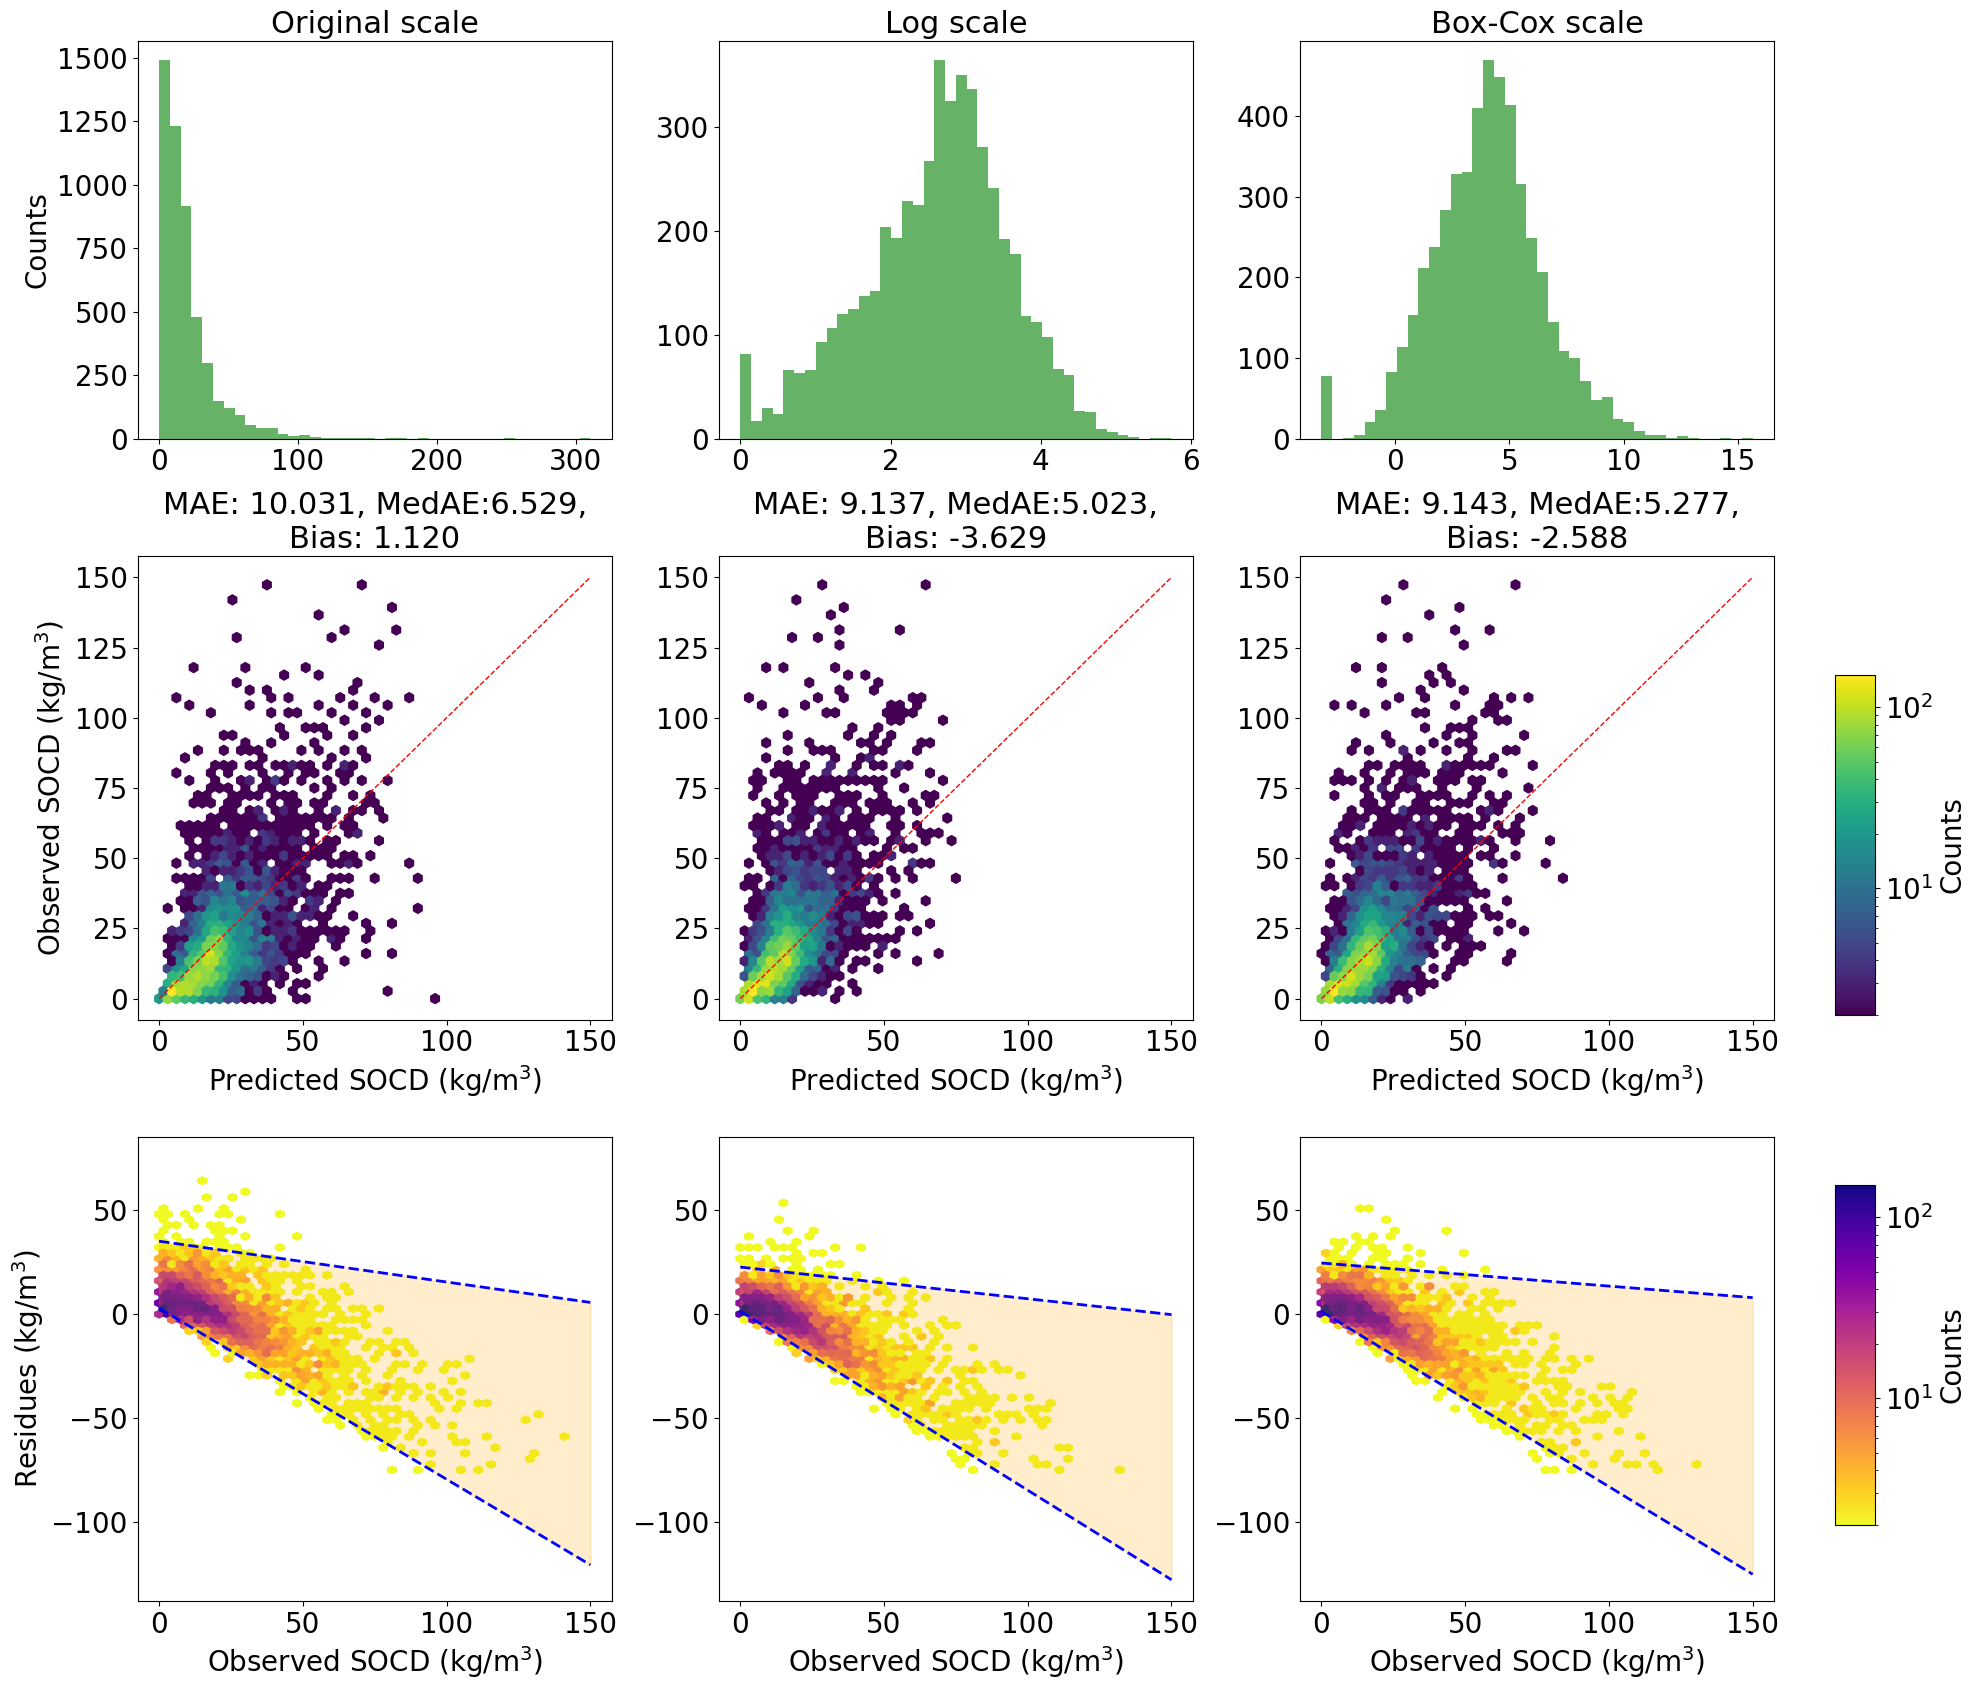

In [11]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3, 3, figsize=(20, 17), gridspec_kw={'height_ratios': [0.9, 1.05, 1.05]})

# Row 1: Share y-labels only (manually set the ticks and labels)
# axs[0, 1].sharey(axs[0, 0])
# axs[0, 2].sharey(axs[0, 0])
# Row 2 and 3: Share both y-axis and y-labels
axs[1, 1].sharey(axs[1, 0])
axs[1, 2].sharey(axs[1, 0])
axs[2, 1].sharey(axs[2, 0])
axs[2, 2].sharey(axs[2, 0])

# Plot histograms of the original data, log1p-transformed data, and Box-Cox-transformed data
axs[0, 0].hist(data_ori, bins=40, density=False, alpha=0.6, color='g')
axs[0, 0].set_title('Original scale', fontsize=22)
axs[0, 0].set_ylabel('Counts', fontsize=20)
axs[0, 0].tick_params(axis='both', labelsize=20)

axs[0, 1].hist(data_log1p, bins=40, density=False, alpha=0.6, color='g')
axs[0, 1].set_title('Log scale', fontsize=22)
axs[0, 1].tick_params(axis='both', labelsize=20)

axs[0, 2].hist(data_boxcox, bins=40, density=False, alpha=0.6, color='g')
axs[0, 2].set_title('Box-Cox scale', fontsize=22)
axs[0, 2].tick_params(axis='both', labelsize=20)


# Predictions
x_min, x_max = 0, 150
y_min, y_max = 0, 150

# Determine global color map limits for hexbin plots in row 1
vmin = 2 #min(np.min(pred['ocd_ori']), np.min(pred['ocd_log1p_ori']), np.min(pred['ocd_boxcox_ori']))
vmax = 150 # max(np.max(pred['ocd_ori']), np.max(pred['ocd_log1p_ori']), np.max(pred['ocd_boxcox_ori']))

# Original-scale model
hb1 = axs[1, 0].hexbin(pred['ocd_ori'], pred['ocd_true'], gridsize=50, mincnt=1, extent=[x_min, x_max, y_min, y_max], bins='log', vmin=vmin, vmax=vmax)
axs[1, 0].set_title(f'MAE: {mae_ori:.3f}, MedAE:{medae_ori:.3f},\nBias: {bias_ori:.3f}', fontsize=22) #, CCC: {ccc_ori:.3f}
axs[1, 0].set_ylabel('Observed SOCD (kg/m$^3$)', fontsize=20)
axs[1, 0].set_xlabel('Predicted SOCD (kg/m$^3$)', fontsize=20)
axs[1, 0].plot([x_min, x_max], [y_min, y_max], color='red', linestyle='--', linewidth=1)  # 1:1 line
axs[1, 0].tick_params(axis='both', labelsize=20)

# Log1p-scale model
hb2 = axs[1, 1].hexbin(pred['ocd_log1p_ori'], pred['ocd_true'], gridsize=50, mincnt=1, extent=[x_min, x_max, y_min, y_max], bins='log', vmin=vmin, vmax=vmax)
axs[1, 1].set_title(f'MAE: {mae_log1p:.3f}, MedAE:{medae_log1p:.3f},\nBias: {bias_log1p:.3f}', fontsize=22) #, CCC: {ccc_log1p:.3f}
axs[1, 1].set_xlabel('Predicted SOCD (kg/m$^3$)', fontsize=20)
axs[1, 1].plot([x_min, x_max], [y_min, y_max], color='red', linestyle='--', linewidth=1)  # 1:1 line
axs[1, 1].tick_params(axis='both', labelsize=20)

# Boxcox-scale model
hb3 = axs[1, 2].hexbin(pred['ocd_boxcox_ori'], pred['ocd_true'], gridsize=50, mincnt=1, extent=[x_min, x_max, y_min, y_max], bins='log', vmin=vmin, vmax=vmax)
axs[1, 2].set_title(f'MAE: {mae_boxcox:.3f}, MedAE:{medae_boxcox:.3f},\nBias: {bias_boxcox:.3f}', fontsize=22) #, CCC: {ccc_boxcox:.3f}
axs[1, 2].set_xlabel('Predicted SOCD (kg/m$^3$)', fontsize=20)
axs[1, 2].plot([x_min, x_max], [y_min, y_max], color='red', linestyle='--', linewidth=1)  # 1:1 line
axs[1, 2].tick_params(axis='both', labelsize=20)

# Single colorbar for all hexbin plots in the second row
cbar_ax = fig.add_axes([0.92, 0.4, 0.02, 0.2])
cb = fig.colorbar(hb1, cax=cbar_ax)
cb.set_label('Counts', fontsize=20)
cb.ax.tick_params(labelsize=20)

# Residuals
x_min, x_max = 0, 150
y_min, y_max = -75, 75

# Original-scale residuals
residual_ori = pred['ocd_ori'] - pred['ocd_true']
hb4 = axs[2, 0].hexbin(pred['ocd_true'], residual_ori, gridsize=50, mincnt=1, bins='log', extent=[x_min, x_max, y_min, y_max], cmap='plasma_r', vmin=vmin, vmax=vmax)
axs[2, 0].set_xlabel('Observed SOCD (kg/m$^3$)', fontsize=20)
axs[2, 0].set_ylabel('Residues (kg/m$^3$)', fontsize=20)
axs[2, 0].tick_params(axis='both', labelsize=20)
# axs[2, 2].set_xlim([0, 150])
# axs[2, 2].set_ylim([-75, 75])
fit_boundary_lines_and_fill(pred['ocd_true'], residual_ori, axs[2, 0], x_fit_range=(0, 50), x_plot_range=(0, 150))

# Log1p-scale residuals
residual_log = pred['ocd_log1p_ori'] - pred['ocd_true']
hb5 = axs[2, 1].hexbin(pred['ocd_true'], residual_log, gridsize=50, mincnt=1, bins='log', extent=[x_min, x_max, y_min, y_max], cmap='plasma_r', vmin=vmin, vmax=vmax)
axs[2, 1].set_xlabel('Observed SOCD (kg/m$^3$)', fontsize=20)
axs[2, 1].tick_params(axis='both', labelsize=20)
# axs[2, 2].set_xlim([0, 150])
# axs[2, 2].set_ylim([-75, 75])
fit_boundary_lines_and_fill(pred['ocd_true'], residual_log, axs[2, 1], x_fit_range=(0, 50), x_plot_range=(0, 150))

# Boxcox-scale residuals
residual_boxcox = pred['ocd_boxcox_ori'] - pred['ocd_true']
hb6 = axs[2, 2].hexbin(pred['ocd_true'], residual_boxcox, gridsize=50, mincnt=1, bins='log', extent=[x_min, x_max, y_min, y_max], cmap='plasma_r', vmin=vmin, vmax=vmax)
axs[2, 2].set_xlabel('Observed SOCD (kg/m$^3$)', fontsize=20)
axs[2, 2].tick_params(axis='both', labelsize=20)
# axs[2, 2].set_xlim([0, 150])
# axs[2, 2].set_ylim([-75, 75])
fit_boundary_lines_and_fill(pred['ocd_true'], residual_boxcox, axs[2, 2], x_fit_range=(0, 50), x_plot_range=(0, 150))

# Single colorbar for all hexbin plots in the third row
cbar_ax_residual = fig.add_axes([0.92, 0.1, 0.02, 0.2])
cb_residual = fig.colorbar(hb4, cax=cbar_ax_residual)
cb_residual.set_label('Counts', fontsize=20)
cb_residual.ax.tick_params(labelsize=20)

# Adjust layout and save plot
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for the colorbars
plt.savefig(f'{folder_path}/figure/plot_box.log.ori.pdf', dpi=300)
plt.show()


The **top panel**, histograms, illustrates that after applying the Log1p and Box-Cox transformations, the distributions become more symmetric, though they remain non-normal.

The **middle panel**, accuracy plots, and the **bottom panel**, residual plots, confirm that underestimation occurs in both the Log1p and Box-Cox transformations, and is less pronounced in the no-transformation (original) model. This observation aligns with the bias.

Compared to the original scale, the transformed models produce narrower residuals and tend to overestimate SOCD less, although all models occasionally underestimate SOCD. This result aligns with the absolute error metrics MAE and MedAE.

# Based on these findings, we opted to perform all further analyses using the log-transformed data.
